# House Price Prediction

Author: Rafael Godoy

LinkedIn: https://www.linkedin.com/in/Rafael-Godoy-ML-Eng

Github: https://github.com/RafaelSilvaGodoy

In this notebook a model will be built to classify if a house costs over $220,000.

All the CRISP-DM methodology will be applied as well as pipelines for deployment.

The dataset and the dataset dictionary are avaiable at [Kaggle](https://www.kaggle.com/c/neolen-house-price-prediction/overview).


In [1]:
# Data manipulation
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import numpy as np

# Data treatment and models
from imblearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import xgboost as xgb

# Results Validation
from sklearn.model_selection import cross_val_score
from sklearn.metrics import plot_confusion_matrix


import random
# Set a random seed for reproducibility.
random.seed(42)

# Data Acquisiton

In [2]:
df = pd.read_csv("house_price.csv")
df.sample(4)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
606,607,20,RL,82.0,12464,Pave,NaN,IR2,Low,AllPub,...,0,NaN,GdPrv,NaN,0,11,2009,WD,Normal,152000
601,602,50,RM,50.0,9000,Pave,NaN,Reg,Bnk,AllPub,...,0,NaN,NaN,NaN,0,12,2007,WD,Normal,141000
1137,1138,50,RL,54.0,6342,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2010,WD,Normal,94000
1011,1012,90,RL,75.0,9825,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2010,WD,Normal,100000


# Analysing Dataset

In [3]:
# A cell that shows the unique values of the object variables and save their columns name for future use.

columns = df.columns.to_list()
aux_obj = []

for c in columns:
  if (type(df[c][0]) != type(df['Id'][0])) and (type(df[c][0]) != type(df['LotFrontage'][0])):
    aux_obj.append(columns[columns.index(c)])

In [4]:
# A cell that shows the amount of NaN in each colum and save the columns name for future use.
aux_nan = []

for c in columns:
  if df[c].isnull().sum():
    aux_nan.append(columns[columns.index(c)])

In [5]:
df.corr().style.background_gradient()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
Id,1.000000,0.011156,-0.010601,-0.033226,-0.028365,0.012609,-0.012713,-0.021998,-0.050298,-0.005024,-0.005968,-0.007940,-0.015415,0.010496,0.005590,-0.044230,0.008273,0.002289,-0.020155,0.005587,0.006784,0.037719,0.002951,0.027239,-0.019772,0.000072,0.016570,0.017634,-0.029643,-0.000477,0.002889,-0.046635,0.001330,0.057044,-0.006242,0.021172,0.000712,-0.021917
MSSubClass,0.011156,1.000000,-0.386347,-0.139781,0.032628,-0.059316,0.027850,0.040581,0.022936,-0.069836,-0.065649,-0.140759,-0.238518,-0.251758,0.307886,0.046474,0.074853,0.003491,-0.002333,0.131608,0.177354,-0.023438,0.281721,0.040380,-0.045569,0.085072,-0.040110,-0.098672,-0.012579,-0.006100,-0.012037,-0.043825,-0.026030,0.008283,-0.007683,-0.013585,-0.021407,-0.084284
LotFrontage,-0.010601,-0.386347,1.000000,0.426095,0.251646,-0.059213,0.123349,0.088866,0.193458,0.233633,0.049900,0.132644,0.392075,0.457181,0.080177,0.038469,0.402797,0.100949,-0.007234,0.198769,0.053532,0.263170,-0.006069,0.352096,0.266639,0.070250,0.285691,0.344997,0.088521,0.151972,0.010700,0.070029,0.041383,0.206167,0.003368,0.011200,0.007450,0.351799
LotArea,-0.033226,-0.139781,0.426095,1.000000,0.105806,-0.005636,0.014228,0.013788,0.104160,0.214103,0.111170,-0.002618,0.260833,0.299475,0.050986,0.004779,0.263116,0.158155,0.048046,0.126031,0.014259,0.119690,-0.017784,0.190015,0.271364,-0.024947,0.154871,0.180403,0.171698,0.084774,-0.018340,0.020423,0.043160,0.077672,0.038068,0.001205,-0.014261,0.263843
OverallQual,-0.028365,0.032628,0.251646,0.105806,1.000000,-0.091932,0.572323,0.550684,0.411876,0.239666,-0.059119,0.308159,0.537808,0.476224,0.295493,-0.030429,0.593007,0.111098,-0.040150,0.550600,0.273458,0.101676,-0.183882,0.427452,0.396765,0.547766,0.600671,0.562022,0.238923,0.308819,-0.113937,0.030371,0.064886,0.065166,-0.031406,0.070815,-0.027347,0.790982
OverallCond,0.012609,-0.059316,-0.059213,-0.005636,-0.091932,1.000000,-0.375983,0.073741,-0.128101,-0.046231,0.040229,-0.136841,-0.171098,-0.144203,0.028942,0.025494,-0.079686,-0.054942,0.117821,-0.194149,-0.060769,0.012980,-0.087001,-0.057583,-0.023820,-0.324297,-0.185758,-0.151521,-0.003334,-0.032589,0.070356,0.025504,0.054811,-0.001985,0.068777,-0.003511,0.043950,-0.077856
YearBuilt,-0.012713,0.027850,0.123349,0.014228,0.572323,-0.375983,1.000000,0.592855,0.315707,0.249503,-0.049107,0.149040,0.391452,0.281986,0.010308,-0.183784,0.199010,0.187599,-0.038162,0.468271,0.242656,-0.070651,-0.174800,0.095589,0.147716,0.825667,0.537850,0.478954,0.224880,0.188686,-0.387268,0.031355,-0.050364,0.004950,-0.034383,0.012398,-0.013618,0.522897
YearRemodAdd,-0.021998,0.040581,0.088866,0.013788,0.550684,0.073741,0.592855,1.000000,0.179618,0.128451,-0.067759,0.181133,0.291066,0.240379,0.140024,-0.062419,0.287389,0.119470,-0.012337,0.439046,0.183331,-0.040581,-0.149598,0.191740,0.112581,0.642277,0.420622,0.371600,0.205726,0.226298,-0.193919,0.045286,-0.038740,0.005829,-0.010286,0.021490,0.035743,0.507101
MasVnrArea,-0.050298,0.022936,0.193458,0.104160,0.411876,-0.128101,0.315707,0.179618,1.000000,0.264736,-0.072319,0.114442,0.363936,0.344501,0.174561,-0.069071,0.390857,0.085310,0.026673,0.276833,0.201444,0.102821,-0.037610,0.280682,0.249070,0.252691,0.364204,0.373066,0.159718,0.125703,-0.110204,0.018796,0.061466,0.011723,-0.029815,-0.005965,-0.008201,0.477493
BsmtFinSF1,-0.005024,-0.069836,0.233633,0.214103,0.239666,-0.046231,0.249503,0.128451,0.264736,1.000000,-0.050117,-0.495251,0.522396,0.445863,-0.137079,-0.064503,0.208171,0.649212,0.067418,0.058543,0.004262,-0.107355,-0.081007,0.044316,0.260011,0.153484,0.224054,0.296970,0.204306,0.111761,-0.102303,0.026451

The matrix shows a high correlation (over 0.40) between SalePrice and the other variables, indicating that the models should do a good job classifing the results.

# Preprocessing

The strategy chosen to treat the missing values was to substitute them into "NA" in object-type variables and into 0 for numeric-type variables.

 Although some columns have most of their values missing, I opted to keep them in the process to extract some info of the remaning values and if the models don't find it usefull, they will automatically attribute a low weight to them.

In [6]:
for col in aux_obj:
  df[col].fillna("NA", inplace=True)

for col in aux_nan:
  df[col].fillna(0, inplace=True)

df.isnull().values.any()

False

Before begin treating the data, the database was splited into X/Y as also as train/test sets.

In [7]:

label = df["SalePrice"] > 220000

feat_cols = df.columns.tolist()
feat_cols.remove("SalePrice")
feat = df[feat_cols]

X_train, X_test, y_train, y_test = train_test_split(feat, label, random_state = 1)

The first step of treatment was to Encode de object-type variables using the Label Encoder method. 

In [8]:
# LabelEncoder
le = dict()

for col in aux_obj:
  le[col] = LabelEncoder()
  X_train[col] = le[col].fit_transform(X_train[col])

<ipython-input-8-270b00c9eee3>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[col] = le[col].fit_transform(X_train[col])


It was noticed that a few untracked labels appeared in the test dataset that weren't contained in the train dataset.
To solve this problem, this step was created to check if there are any untracked labels in the object-type columns, and if so, drop the rows that they appear. 


In [9]:
df_aux = pd.DataFrame(X_test)
df_aux["label"] = y_test
df_aux.reset_index(inplace = True)

index_list = []


for col in aux_obj:

  for item in list(df_aux[col].unique()):
    if not item in list(le[col].classes_):
      j = 0
      for i in df_aux[col]:
        if (df_aux[col].iloc[j] == item):
          index_list.append(j)
        j += 1

df_aux.drop(index_list, inplace=True)

X_test = df_aux[feat_cols]
y_test = df_aux["label"].to_numpy()

for col in aux_obj:
  X_test[col] = le[col].transform(X_test[col])

<ipython-input-9-ae1caea567f1>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[col] = le[col].transform(X_test[col])


As a few models will be tested, it was opted to build a pipeline to treat the data and test the models.

Once the data was Encoded on the previous cells, the pipelines will standardise -> reduce dimentions -> balance -> apply model.

In [23]:
# Logistic regression pipeline.
pipe_lr = make_pipeline(StandardScaler(),PCA(n_components=10),SMOTE(),LogisticRegression(random_state=1,solver='lbfgs'))
pipe_lr.fit(X_train, y_train)

# xgboost pipeline.
pipe_xgb = make_pipeline(StandardScaler(),PCA(n_components=10),SMOTE(),
xgb.XGBClassifier(n_estimators=300,max_depth=15, scale_pos_weight=400,use_label_encoder=False, eval_metric='logloss'))
pipe_xgb.fit(X_train, y_train)

# Suport vector machine pipeline.
pipe_svm = make_pipeline(StandardScaler(),PCA(n_components=10),SMOTE(),SVC())
pipe_svm.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('pca', PCA(n_components=10)), ('smote', SMOTE()),
                ('svc', SVC())])

# Validating

In order to validade the models, two indicators were used: 

Cross validation accuracy -> Avarage accuracy of different splits of the training set.

Confusion matrix          -> The assertiveness of the true-positive, true-negative, false-negative and false-positive.

CV accuracy: 0.911 +/- 0.014


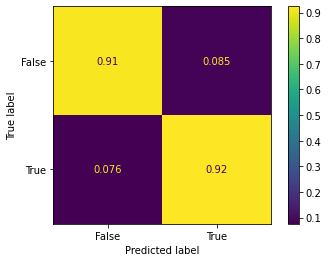

In [11]:
scores = cross_val_score(estimator=pipe_lr,X=X_train, y=y_train,cv=10,n_jobs=1)

print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores),np.std(scores)))

plot_confusion_matrix(pipe_lr, X_test, y_test, normalize="true")

CV accuracy: 0.910 +/- 0.026


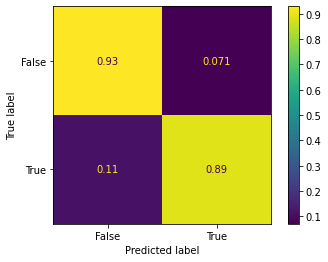

In [24]:
scores = cross_val_score(estimator=pipe_xgb,X=X_train, y=y_train,cv=10,n_jobs=1)

print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores),np.std(scores)))

plot_confusion_matrix(pipe_xgb, X_test, y_test, normalize="true")

CV accuracy: 0.910 +/- 0.017


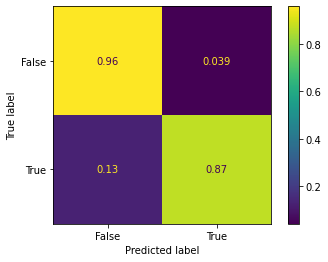

In [13]:
scores = cross_val_score(estimator=pipe_svm,X=X_train, y=y_train,cv=10,n_jobs=1)

print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores),np.std(scores)))

plot_confusion_matrix(pipe_svm, X_test, y_test, normalize="true")

The results of each model were:

Logistic Regression = 0.911 +/- 0.014

Xgboost             = 0.910 +/- 0.026

SVM                 = 0.910 +/- 0.017

All the models tested had almost the same performance, close to 90%.

To improve our model, an extra model was created using the predicted values of the previous models as input to calculated a more accurate output. 


# Ensemble models

In [15]:
def models_concat(model1, model2, model3, x):
    ''' Converts the models outputs into a pd.DataFrame.
    Args
        x:The variable that the models will make a prediction. 
        model1: Model number 1
        model2: Model number 2
        model3: Model number 3
    Return
        y_pred_df: pd.DataFrame with the model's predictions.
    '''
    y_model1 = model1.predict(x)
    y_model2 = model2.predict(x)
    y_model3 = model3.predict(x)

    y_pred_df = pd.DataFrame()
    y_pred_df['y1'] = y_model1
    y_pred_df['y2'] = y_model2
    y_pred_df['y3'] = y_model3

    return(y_pred_df)


In [25]:
y_pred_df  = models_concat(pipe_lr, pipe_xgb, pipe_svm, X_train)
y_pred_df.head()

,y1,y2,y3
0,True,1,True
1,False,1,True
2,False,0,False
3,False,0,False
4,False,0,False


In [26]:
pipe_models = make_pipeline(SMOTE(),xgb.XGBClassifier(n_estimators=500,max_depth=20, scale_pos_weight=10_000,
                                                      use_label_encoder=False, eval_metric='logloss'))

pipe_models.fit(y_pred_df, y_train)

Pipeline(steps=[('smote', SMOTE()),
                ('xgbclassifier',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, eval_metric='logloss',
                               gamma=0, gpu_id=-1, importance_type='gain',
                               interaction_constraints='',
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth=20, min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=500,
                               n_jobs=8, num_parallel_tree=1, random_state=0,
                               reg_alpha=0, reg_lambda=1,
                               scale_pos_weight=10000, subsample=1,
                               tree_method='exact', use_label_encoder=False,
                               validate_parameters=1, verbosity=None))])


CV accuracy: 0.991 +/- 0.011


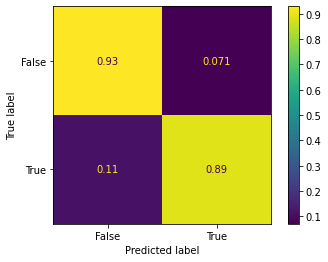

In [27]:
scores = cross_val_score(estimator=pipe_models,X=y_pred_df, y=y_train,cv=10,n_jobs=1)

y_pred  = models_concat(pipe_lr, pipe_xgb, pipe_svm, X_test)

plot_confusion_matrix(pipe_models, y_pred, y_test, normalize="true")

print("")
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores),np.std(scores)))

# Conclusion


-------------------------------------
Combined Models     = 0.991 +/- 0.011
-------------------------------------

In this particular problem when the models are combined the final model gets a higher avarage accuracy and more precision (lower standard deviation) when compared to each model individually.

The result was satisfactory but could be improved by applying a better data treatment and also adding different machine learning models into de pipelines.